# Movie Recommender using Weighted Hybrid Recommendation System

Pada _Hybrid Recommender Systems: Survey and Experiments_, Burke mengelompokkan _hybrid recommender system_ ke dalam 7 pendekatan.

Referensi: Burke, R. Hybrid Recommender Systems: Survey and Experiments. _User Model User-Adap Inter 12_, 331–370 (2002). https://doi.org/10.1023/A:1021240730564


In [1]:
 # pip install xgboost

In [2]:
# load library
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb

In [15]:
data_path = 'D:\\JUPYTER NOTEBOOK\\TUGAS AKHIR\\data\\data_obat.csv'
train_path = data_path 
test_path = data_path 

In [16]:
df_rating = pd.read_csv(train_path, delimiter = '\t', names = ['UserId', 'ItemId', 'Effectiveness'])
test = pd.read_csv(test_path, delimiter = '\t', names = ['UserId', 'ItemId', 'Effectiveness'])

In [17]:
x_train = df_rating[['UserId', 'ItemId']]
y_train = df_rating[['Effectiveness']]
x_test = test[['UserId', 'ItemId']]
y_test = test['Effectiveness']

Selanjutnya, kita melakukan rekayasa fitur (_feature engineering_) pada data pengguna dan film agar sesuai dengan model, di mana:
- _One-hot Encoding_ pada pekerjaan pengguna (_user occupation_) dan genre film (_movie genre_)
- _Label Encoding_ pada jenis kelamin pengguna (_user gender_)

In [22]:
# load data
user = pd.read_csv(data_path, delimiter = '|', names = ['UserId', 'ItemId'])[['UserId', 'ItemId']]
rating = pd.read_csv(data_path, delimiter = '|', names = ['Effectiveness']).Effectiveness.to_list()

In [24]:
# # perform one-hot encoding on the user's occupation column, and label encoding on the gender column
# user[occupation_col_names] = preprocessing.OneHotEncoder(sparse = False).fit_transform(user.occupation.to_numpy().reshape(-1,1))
# user['gender'] = preprocessing.LabelEncoder().fit_transform(user.gender)
# user = user.drop(['occupation'], axis = 1)

In [25]:
x_train = x_train.join(user.set_index('UserId'), on = 'UserId').join(item.set_index('ItemId'), on = 'ItemId')
x_test = x_test.join(user.set_index('UserId'), on = 'UserId').join(item.set_index('ItemId'), on = 'ItemId')
x_train.head()

ValueError: columns overlap but no suffix specified: Index(['ItemId'], dtype='object')

## BATAS

### Pengaturan Model Rekomendasi

In [26]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(x_train, y_train)

pred1 = model1.predict(x_test)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:UserId

Untuk membangun model 2 — _item-item collaborative filtering model_, kita menggunakan kode dari [Overview of Item-Item Collaborative Filtering Recommendation System oleh Jeffery Chiang](https://medium.com/geekculture/overview-of-item-item-collaborative-filtering-recommendation-system-64ee15b24bb8).

In [ ]:
def compute_single_prediction(userid, itemid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    numerate = np.dot(user_rating, item_similarity)
    denom = item_similarity[user_rating > 0].sum()
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

def compute_all_prediction(test_set, pred_func, similarity_mtx, utility, **kwargs):
    pred = []
    for data in test_set:
        res = pred_func(userid = data[0], 
                        itemid = data[1], 
                        similarity_mtx = similarity_mtx, 
                        utility = utility, 
                        **kwargs)
        pred.append(res)
    return pred

# model 2
# construct the utility matrix
utility = df.pivot(index = 'itemid', columns = 'userid', values = 'rating')
utility = utility.fillna(0)

# calculate the similarity
similarity_mtx = 1 - squareform(pdist(utility, 'cosine'))

pred2 = compute_all_prediction(test[['userid', 'itemid']].to_numpy(),
                      compute_single_prediction,
                      similarity_mtx,
                      utility)
pred2 = np.array(pred2)

rmse = np.sqrt(np.mean((pred2 - y_test.to_numpy())**2))
print(f'rmse of item-item collaborative filtering = {rmse}')

rmse of item-item collaborative filtering = 1.0452369678411928


Kita dapat membangun _weighted hybrid_ dengan menggabungkan 2 model secara linier, yang mampu menghasilkan kinerja yang lebih baik. Seperti yang ditunjukkan pada plot di bawah ini, kita dapat melihat bahwa bobot paling baik adalah ketika bobotnya sekitar 0,4 dalam set data kita.

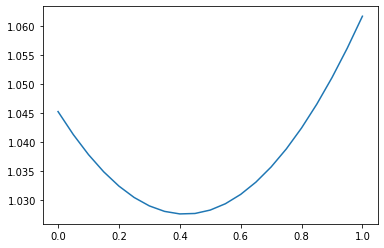

In [ ]:
chart_val = []

w = np.linspace(0,1,21)

for i in w:
    pred4 = pred1*i + pred2*(1-i)
    rmse = np.sqrt(np.mean((pred4 - y_test.to_numpy())**2))
    chart_val.append([i, rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

---